In [1]:
import os
os.environ['HF_HOME'] = '/workspace/huggingface'

from transformer_lens import HookedTransformer, ActivationCache, utils
import torch

if torch.backends.mps.is_available():
    device = "mps"
else:
    device = "cuda" if torch.cuda.is_available() else "cpu"

print(f"Device: {device}")

import plotly.graph_objects as go
from plotly.offline import init_notebook_mode, iplot
import numpy as np
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
from functools import partial

init_notebook_mode(connected=True)

Device: cuda


In [2]:
model = HookedTransformer.from_pretrained('gpt2', device=device)

model.eval()
model.set_use_attn_result(True)
model.set_use_attn_in(True)
model.set_use_hook_mlp_in(True)
model.set_use_split_qkv_input(True)

/workspace/venv/lib/python3.10/site-packages/huggingface_hub/file_download.py:1132: FutureWarning:

`resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.



Loaded pretrained model gpt2 into HookedTransformer


In [80]:
clean_prompt = '''I'm Davide, I'm 20 years old and I live in Rome.
{
    "name": "Davide",
    "age": "20",
    "city": "Rome"
}

My name is Paul and I live in San Francisco. I've just turned 12.
{'''

corrupted_prompt = '''I'm Davide and I'm 20 years old.
{
    "name": "Davide",
    "age": "20"
}

Hi, I'm Laura and I'm 25.
{
    "name": "'''

#My name is Paul and I've just turned 12.
#{
#    "name": "Paul",
#    "age": 12
#} Hi, I'm Laura and I'm 25.

clean_prompt = '''David is a student at Stanford and Mary works at McDonald.
{
    "entities": [
        {"id": 0, "name": "Davide"},
        {"id": 1, "name": "Stanford"},
        {"id": 2, "name": "Mary"},
        {"id": 3, "name": "McDonald"}
    ]
}

Susan works at Walmart while John studies at NYU.
{
    "entities": [
        {"id": 0, "name": "'''

corrupted_prompt = '''David is a student at Stanford and Mary works at McDonald.
{
    "entities": [
        {"id": 0, "name": "Davide"},
        {"id": 1, "name": "Stanford"},
        {"id": 2, "name": "Mary"},
        {"id": 3, "name": "McDonald"}
    ]
}

John works at Walmart while Susan studies at NYU.
{
    "entities": [
        {"id": 0, "name": "'''

clean_prompt = "This is amazing | positive\nIt has been a shame | negative\nIt was good overall |"
corrupted_prompt = "This is amazing | positive\nIt has been a shame | negative\nIt was bad overall |"

### Patching

In [81]:
from transformer_lens.utils import test_prompt

test_prompt(clean_prompt, 'positive', model)

Tokenized prompt: ['<|endoftext|>', 'This', ' is', ' amazing', ' |', ' positive', '\n', 'It', ' has', ' been', ' a', ' shame', ' |', ' negative', '\n', 'It', ' was', ' good', ' overall', ' |']
Tokenized answer: [' positive']


Performance on answer token:
Rank: 0        Logit: 17.24 Prob: 70.66% Token: | positive|

Top 0th token. Logit: 17.24 Prob: 70.66% Token: | positive|
Top 1th token. Logit: 15.19 Prob:  9.04% Token: | negative|
Top 2th token. Logit: 14.84 Prob:  6.41% Token: | good|
Top 3th token. Logit: 13.56 Prob:  1.78% Token: | bad|
Top 4th token. Logit: 12.37 Prob:  0.54% Token: | great|
Top 5th token. Logit: 12.15 Prob:  0.43% Token: | positives|
Top 6th token. Logit: 11.87 Prob:  0.33% Token: | very|
Top 7th token. Logit: 11.86 Prob:  0.32% Token: | nice|
Top 8th token. Logit: 11.80 Prob:  0.30% Token: | happy|
Top 9th token. Logit: 11.36 Prob:  0.20% Token: | awesome|


Ranks of the answer tokens: [(' positive', 0)]

In [82]:
import os
import sys

current_dir = os.getcwd()
atp_dir = os.path.abspath(os.path.join(current_dir, '..', '..'))
sys.path.append(atp_dir)

from atp import Patching

patching = Patching(model, 'atp')

In [83]:
a_clean = ' positive'
a_corr = ' negative'

a_clean_token = model.to_single_token(a_clean)

patching.patching(clean_prompt, a_clean, corrupted_prompt, a_corr, component='attn_all')

Clean logit difference: 2.056
Corrupted logit difference: 1.425
Patching...


In [84]:
fig = patching.plot()
fig.write_html("fig.html")

In [85]:
def head_modifier_hook(x, hook, head_id, lam=1.2):
    x[:, -1, head_id, :] = lam * x[:, -1, head_id, :]
    return x

In [88]:
# [(8, 11, -1), (9, 6, 1), (9, 9, 1), (10, 0, 1), (10, 1, 1), (10, 7, -1), (10, 10, 1), (11, 10, -1)]
heads = [(8, 11), (9, 6), (10, 0), (10, 1)]
# 9,9
topk_token_probas = []  # List to store topk token probabilities
lams = np.linspace(1, 10, 50)

for lam in tqdm(lams):
    with torch.no_grad():
        proba = model.run_with_hooks(
            model.to_tokens(corrupted_prompt),
            fwd_hooks=[
                (
                    f"blocks.{l}.attn.hook_result",
                    partial(head_modifier_hook, head_id=h, lam=lam),
                ) for l, h in heads
            ]
        ).softmax(-1)
        
        if lam == 1:
            vals, idxs = proba.topk(8, dim=-1)
            initial_tokens = idxs[0, -1].cpu().tolist()
            if a_clean_token not in initial_tokens:
                initial_tokens.append(a_clean_token)
        else:
            vals = proba[..., initial_tokens]
        
        topk_token_probas.append(vals[0, -1, :].cpu().numpy().tolist())


100%|██████████| 50/50 [00:01<00:00, 30.32it/s]


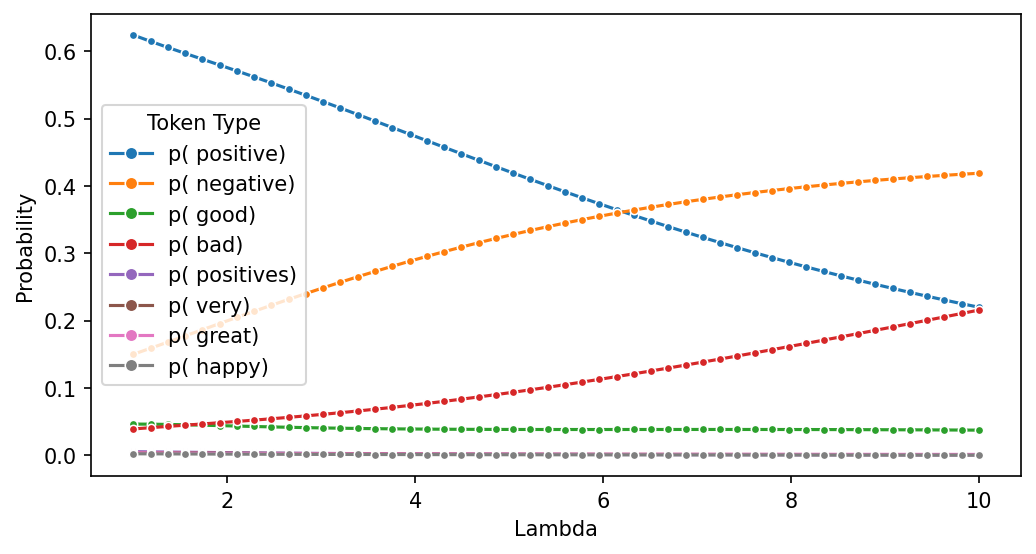

In [89]:
import pandas as pd

fig = plt.figure(figsize=(8, 4), dpi=150)

data = pd.DataFrame(topk_token_probas, columns=[f"p({tok})" for tok in model.to_str_tokens(torch.tensor(initial_tokens))])
data['Lambda'] = lams
data = data.melt(id_vars='Lambda', var_name='Token Type', value_name='Probability')

ax = sns.lineplot(data=data, x='Lambda', y='Probability', hue='Token Type', marker='o')
tmp =[line.set_markersize(4) for line in ax.lines]

In [22]:
heads = [(8, 11), (9, 6), (10, 0), (10, 1), (11, 10)]
lam = 3

tokens = model.to_tokens(clean_prompt)
max_new_tokens = 64

for i in tqdm(range(max_new_tokens)): 
    with torch.no_grad():
        new_tok = model.run_with_hooks(
            tokens,
            fwd_hooks=[
                (
                    f"blocks.{l}.attn.hook_result",
                    partial(head_modifier_hook, head_id=h, lam=lam),
                ) for l, h in heads
            ]
        ).argmax(-1)[:, -1, None]

    tokens = torch.cat([tokens, new_tok], dim=-1)

print(model.to_string(tokens)[0])

100%|██████████| 64/64 [00:01<00:00, 36.37it/s]

<|endoftext|>David is a student at Stanford and Mary works at McDonald.
{
    "entities": [
        {"id": 0, "name": "Davide"},
        {"id": 1, "name": "Stanford"},
        {"id": 2, "name": "Mary"},
        {"id": 3, "name": "McDonald"}
    ]
}

Susan works at Walmart while John studies at NYU.
{
    "entities": [
        {"id": 0, "name": "John"},
        {"id": 1, "name": "McDonald"},
       {"id": 2, "name": "McDonald"},
       {"id": 3, "name": "McDonald"},

{



### AtP

In [103]:
patching = Patching(model, 'atp')

In [106]:
x_clean = clean_prompt
x_corr = corrupted_prompt

a_clean = 'Susan'
a_corr = 'John'

patching.patching(x_clean, a_clean, x_corr, a_corr, component='attn_k')

Clean logit difference: -2.828
Corrupted logit difference: -2.330
Patching...


In [107]:
fig = patching.plot()
fig.write_html("fig.html")

Promoting heads: L8H11, L9H6, L9H9, L10H0, L10H1, L10H10

Suppression heads: L10H7, L10H11

In [245]:
prompt = '''David is a student at Stanford and Mary works at McDonald.
{
    "entities": [
        {"id": 0, "name": "Davide"},
        {"id": 1, "name": "Stanford"},
        {"id": 2, "name": "Mary"},
        {"id": 3, "name": "McDonald"}
    ]
}

Susan works at Walmart while John studies at NYU.
{
    "entities": [
        {"id": 0, "name": "John"},
        {"id": 1, "name": "Walmart"},
        {"id": 2, "name": "Susan"},'''

In [246]:
def logits_diff(logits, ans, topk=5):
    top_tokens = logits[0, -1].topk(topk).indices.tolist()
    if isinstance(ans, str):
        ans = model.to_single_token(ans)

    if ans in top_tokens:
        top_tokens.remove(ans)
        
    return logits[0, -1, ans] - logits[0, -1, top_tokens].mean(-1)
    
def get_cache_fwd_and_bwd(tokens, ans):
        filter_not_qkv_input = lambda name: "_input" not in name
        model.reset_hooks()
        cache = {}

        def forward_cache_hook(act, hook):
            cache[hook.name] = act.detach()

        model.add_hook(filter_not_qkv_input, forward_cache_hook, "fwd")

        grad_cache = {}

        def backward_cache_hook(act, hook):
            grad_cache[hook.name] = act.detach()

        model.add_hook(filter_not_qkv_input, backward_cache_hook, "bwd")

        value = logits_diff(model(tokens), ans, topk=10)
        value.backward()
        model.reset_hooks()
        return (
            value.item(),
            ActivationCache(cache, model),
            ActivationCache(grad_cache, model),
        )

In [247]:
tokens = model.to_tokens(prompt)
list(enumerate(model.to_str_tokens(prompt)))

[(0, '<|endoftext|>'),
 (1, 'David'),
 (2, ' is'),
 (3, ' a'),
 (4, ' student'),
 (5, ' at'),
 (6, ' Stanford'),
 (7, ' and'),
 (8, ' Mary'),
 (9, ' works'),
 (10, ' at'),
 (11, ' McDonald'),
 (12, '.'),
 (13, '\n'),
 (14, '{'),
 (15, '\n'),
 (16, ' '),
 (17, ' '),
 (18, ' '),
 (19, ' "'),
 (20, 'ent'),
 (21, 'ities'),
 (22, '":'),
 (23, ' ['),
 (24, '\n'),
 (25, ' '),
 (26, ' '),
 (27, ' '),
 (28, ' '),
 (29, ' '),
 (30, ' '),
 (31, ' '),
 (32, ' {"'),
 (33, 'id'),
 (34, '":'),
 (35, ' 0'),
 (36, ','),
 (37, ' "'),
 (38, 'name'),
 (39, '":'),
 (40, ' "'),
 (41, 'D'),
 (42, 'av'),
 (43, 'ide'),
 (44, '"},'),
 (45, '\n'),
 (46, ' '),
 (47, ' '),
 (48, ' '),
 (49, ' '),
 (50, ' '),
 (51, ' '),
 (52, ' '),
 (53, ' {"'),
 (54, 'id'),
 (55, '":'),
 (56, ' 1'),
 (57, ','),
 (58, ' "'),
 (59, 'name'),
 (60, '":'),
 (61, ' "'),
 (62, 'Stan'),
 (63, 'ford'),
 (64, '"},'),
 (65, '\n'),
 (66, ' '),
 (67, ' '),
 (68, ' '),
 (69, ' '),
 (70, ' '),
 (71, ' '),
 (72, ' '),
 (73, ' {"'),
 (74, 'id'),


In [248]:
import einops
from tqdm import tqdm

first_output_token_id = 124

patch = torch.zeros(144, len(tokens[0]) - first_output_token_id)

for i in tqdm(range(first_output_token_id, len(tokens[0]))):
    _, cache, grad_cache = get_cache_fwd_and_bwd(tokens[:, :i], tokens[0, i])

    act = cache.stack_head_results(-1)
    grad_act = grad_cache.stack_head_results(-1)

    patch[:, i-first_output_token_id] = einops.reduce(
                grad_act *  act,
                "component batch pos d_model -> component pos",
                "sum",
            )[:, -1]

100%|██████████| 68/68 [00:08<00:00,  8.20it/s]


In [249]:
import plotly.express as px
ys = [f'L{i}H{j}' for i in range(model.cfg.n_layers) for j in range(model.cfg.n_heads)]
xs = [f"{tok} | {i}" for i, tok in enumerate(model.to_str_tokens(prompt)[first_output_token_id:])]

fig = px.imshow(
    patch.cpu().numpy(), 
    x=xs,
    y=ys,
    title=f"Patching results for AtP method",
    color_continuous_scale='RdBu', zmin=-1, zmax=1, aspect='auto'
)
fig.write_html("fig.html")

In [250]:
import plotly.express as px
import numpy as np

layer_id = 8
head_id = 11

data = cache[f'blocks.{layer_id}.attn.hook_pattern'][0, head_id].cpu()
labels = [f"{tok} ({i})" for i, tok in enumerate(model.to_str_tokens(prompt)[:-1])]

# Create the plot using Plotly Express
fig = px.imshow(
    data,
    labels=dict(x="Keys", y="Queries", color="Attention Score"),
    x=labels,
    y=labels,
    title=f'Attention patter at head {head_id} of layer {layer_id}',
    color_continuous_scale="Blues"
)

# Adjust the layout for better readability
fig.update_xaxes(tickangle=35)
fig.update_layout(coloraxis_colorbar=dict(title="Score"))

# Show the plot
fig.write_html("attn_pattern.html")

In [336]:
# Pattern modifier
start = 113
end = 123

def pattern_modifier_hook(x, hook, head_id, pos):
    name_tokens = start + x[:, head_id, pos, start:end].sort(descending=True).indices[0, :4]
    #x[:, head_id, pos, name_tokens] = x[:, head_id, pos, name_tokens].sum() / len(name_tokens)
    #print(name_tokens)
    x[:, head_id, pos, 113] = x[:, head_id, pos, 113] + 10
    #x[:, head_id, pos] = x[:, head_id, pos].softmax(-1)
    return x

In [337]:
prompt = '''David is a student at Stanford and Mary works at McDonald.
{
    "entities": [
        {"id": 0, "name": "Davide"},
        {"id": 1, "name": "Stanford"},
        {"id": 2, "name": "Mary"},
        {"id": 3, "name": "McDonald"}
    ]
}

Susan works at Walmart while John studies at NYU.
{
    "entities": [
        {"id": 0, "name": "'''

In [338]:
print(model.generate(prompt, max_new_tokens=32, temperature=0))

  0%|          | 0/32 [00:00<?, ?it/s]

David is a student at Stanford and Mary works at McDonald.
{
    "entities": [
        {"id": 0, "name": "Davide"},
        {"id": 1, "name": "Stanford"},
        {"id": 2, "name": "Mary"},
        {"id": 3, "name": "McDonald"}
    ]
}

Susan works at Walmart while John studies at NYU.
{
    "entities": [
        {"id": 0, "name": "John"},
        {"id": 1, "name": "John"},
        {"id":


In [339]:
heads = [(8, 3), (8, 11)]
token_ids = [model.to_single_token(tok) for tok in ['Susan', 'John']]
pos = -1

tokens = model.to_tokens(clean_prompt)
max_new_tokens = 32

for i in tqdm(range(max_new_tokens)): 
    with torch.no_grad():
        new_tok = model.run_with_hooks(
            tokens,
            fwd_hooks=[
                (
                    f"blocks.{l}.attn.hook_pattern",
                    partial(pattern_modifier_hook, head_id=h, pos=pos),
                ) for l, h in heads
            ]
        ).argmax(-1)[:, -1, None]
        
        probas = proba[..., token_ids]
        tokens = torch.cat([tokens, new_tok], dim=-1)

100%|██████████| 32/32 [00:00<00:00, 38.12it/s]


In [342]:
print(model.to_string(tokens)[0])

<|endoftext|>David is a student at Stanford and Mary works at McDonald.
{
    "entities": [
        {"id": 0, "name": "Davide"},
        {"id": 1, "name": "Stanford"},
        {"id": 2, "name": "Mary"},
        {"id": 3, "name": "McDonald"}
    ]
}

Susan works at Walmart while John studies at NYU.
{
    "entities": [
        {"id": 0, "name": "Susan Susan Susan Susan Susan Susan Susan Susan Susan Susan Susan Susan Susan Susan Susan Susan Susan Susan Susan Susan Susan Susan Susan Susan Susan Susan Susan Susan Susan Susan Susan Susan


In [341]:
probas[0, -1]

tensor([0.0002, 0.0006], device='cuda:0')

## SAEs

In [35]:
from huggingface_hub import snapshot_download

REPO_ID = "jbloom/GPT2-Small-SAEs-Reformatted"
path = snapshot_download(repo_id=REPO_ID)

Fetching 41 files:   0%|          | 0/41 [00:00<?, ?it/s]

In [36]:
from sae_lens import LMSparseAutoencoderSessionloader
from tqdm import tqdm
import os

saes = []

for l in tqdm(range(model.cfg.n_layers)):
    _, sae_group, activation_store = LMSparseAutoencoderSessionloader.load_pretrained_sae(
        path = os.path.join(path, f"blocks.{l}.hook_resid_pre"), device=device
    )
    sae_group.eval()
    saes.append(sae_group[f'blocks.{l}.hook_resid_pre'])

  0%|          | 0/12 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning:

`resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.



Loaded pretrained model gpt2-small into HookedTransformer
Moving model to device:  cuda


/usr/local/lib/python3.10/dist-packages/datasets/load.py:1486: FutureWarning:

The repository for Skylion007/openwebtext contains custom code which must be executed to correctly load the dataset. You can inspect the repository content at https://hf.co/datasets/Skylion007/openwebtext
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this dataset from the next major release of `datasets`.

  8%|▊         | 1/12 [00:12<02:15, 12.29s/it]

Loaded pretrained model gpt2-small into HookedTransformer
Moving model to device:  cuda


 17%|█▋        | 2/12 [00:22<01:50, 11.05s/it]

Loaded pretrained model gpt2-small into HookedTransformer
Moving model to device:  cuda


 25%|██▌       | 3/12 [00:28<01:20,  8.96s/it]

Loaded pretrained model gpt2-small into HookedTransformer
Moving model to device:  cuda


 33%|███▎      | 4/12 [00:35<01:03,  7.88s/it]

Loaded pretrained model gpt2-small into HookedTransformer
Moving model to device:  cuda


 42%|████▏     | 5/12 [00:40<00:48,  6.93s/it]

Loaded pretrained model gpt2-small into HookedTransformer
Moving model to device:  cuda


 50%|█████     | 6/12 [00:50<00:48,  8.02s/it]

Loaded pretrained model gpt2-small into HookedTransformer
Moving model to device:  cuda


 58%|█████▊    | 7/12 [00:57<00:38,  7.77s/it]

Loaded pretrained model gpt2-small into HookedTransformer
Moving model to device:  cuda


 67%|██████▋   | 8/12 [01:03<00:28,  7.24s/it]

Loaded pretrained model gpt2-small into HookedTransformer
Moving model to device:  cuda


 75%|███████▌  | 9/12 [01:09<00:20,  6.80s/it]

Loaded pretrained model gpt2-small into HookedTransformer
Moving model to device:  cuda


 83%|████████▎ | 10/12 [01:25<00:18,  9.43s/it]

Loaded pretrained model gpt2-small into HookedTransformer
Moving model to device:  cuda


 92%|█████████▏| 11/12 [01:39<00:10, 10.96s/it]

Loaded pretrained model gpt2-small into HookedTransformer
Moving model to device:  cuda


100%|██████████| 12/12 [01:45<00:00,  8.82s/it]


In [38]:
prompt = '''David is a student at Stanford and Mary works at McDonald.
{
    "entities": [
        {"id": 0, "name": "Davide"},
        {"id": 1, "name": "Stanford"},
        {"id": 2, "name": "Mary"},
        {"id": 3, "name": "McDonald"}
    ]
}

Susan works at Walmart while John studies at NYU.
{
    "entities": [
        {"id": 0, "name": "'''

tokens = model.to_tokens(prompt)

In [39]:
from fancy_einsum import einsum
sae_cache = {}
sae_grad_cache = {}

def feature_edit_hook(x, hook, sae, f_id, pos, lam=2):
    sae_out, f_act, *_ = sae(x)
    f_act[:, pos, f_id] = f_act[:, pos, f_id] * lam
    edit = einsum(
        'b p dsae, dsae dm -> b p dm',
        f_act, sae.W_dec
    ) + sae.b_dec

def reconstr_hook(x, hook, sae):
    sae_out, f_act, *_ = sae(x)
    
    # Function to capture the gradient
    def capture_grad(grad):
        sae_grad_cache[hook.name] = grad.clone()

    # Register the hook to capture the gradient
    if f_act.requires_grad:
        f_act.register_hook(capture_grad)
    
    sae_cache[hook.name] = f_act.detach()
    return sae_out

In [40]:
list(enumerate(model.to_str_tokens(prompt)))

[(0, '<|endoftext|>'),
 (1, 'David'),
 (2, ' is'),
 (3, ' a'),
 (4, ' student'),
 (5, ' at'),
 (6, ' Stanford'),
 (7, ' and'),
 (8, ' Mary'),
 (9, ' works'),
 (10, ' at'),
 (11, ' McDonald'),
 (12, '.'),
 (13, '\n'),
 (14, '{'),
 (15, '\n'),
 (16, ' '),
 (17, ' '),
 (18, ' '),
 (19, ' "'),
 (20, 'ent'),
 (21, 'ities'),
 (22, '":'),
 (23, ' ['),
 (24, '\n'),
 (25, ' '),
 (26, ' '),
 (27, ' '),
 (28, ' '),
 (29, ' '),
 (30, ' '),
 (31, ' '),
 (32, ' {"'),
 (33, 'id'),
 (34, '":'),
 (35, ' 0'),
 (36, ','),
 (37, ' "'),
 (38, 'name'),
 (39, '":'),
 (40, ' "'),
 (41, 'D'),
 (42, 'av'),
 (43, 'ide'),
 (44, '"},'),
 (45, '\n'),
 (46, ' '),
 (47, ' '),
 (48, ' '),
 (49, ' '),
 (50, ' '),
 (51, ' '),
 (52, ' '),
 (53, ' {"'),
 (54, 'id'),
 (55, '":'),
 (56, ' 1'),
 (57, ','),
 (58, ' "'),
 (59, 'name'),
 (60, '":'),
 (61, ' "'),
 (62, 'Stan'),
 (63, 'ford'),
 (64, '"},'),
 (65, '\n'),
 (66, ' '),
 (67, ' '),
 (68, ' '),
 (69, ' '),
 (70, ' '),
 (71, ' '),
 (72, ' '),
 (73, ' {"'),
 (74, 'id'),


In [59]:
def feature_editing(model, prompt, tokens):
    
    tokens = [model.to_single_token(tok) for tok in tokens]

    with torch.no_grad():
        proba = model(model.to_tokens(clean_prompt)).softmax(-1)
    
    vals = proba[..., tokens]
    return vals[0, -1, :].cpu().numpy().tolist()

In [98]:
# Feature Editing
tokens = [model.to_single_token(tok) for tok in ['John', 'Susan']]

#features = [(10, 13299)] 
pos = 113

hook_point = f'blocks.{layer_id}.hook_resid_pre'

token_probas = []

lams = np.linspace(-5, 5, 20)

for lam in tqdm(lams):



    
    with model.hooks(
        fwd_hooks=[
            (
                hook_point,
                partial(feature_edit_hook, sae=saes[layer_id], f_id=f_id, pos=pos, lam=lam),
            ) for layer_id, f_id in features
        ]
    ): token_probas.append(feature_editing(model, prompt, ['Susan', 'John']))

100%|██████████| 20/20 [00:01<00:00, 11.23it/s]


In [100]:
token_probas

[[0.008649192750453949, 0.14631010591983795],
 [0.008649192750453949, 0.14631010591983795],
 [0.008649192750453949, 0.14631010591983795],
 [0.008649192750453949, 0.14631010591983795],
 [0.008649192750453949, 0.14631010591983795],
 [0.008649192750453949, 0.14631010591983795],
 [0.008649192750453949, 0.14631010591983795],
 [0.008649192750453949, 0.14631010591983795],
 [0.008649192750453949, 0.14631010591983795],
 [0.008649192750453949, 0.14631010591983795],
 [0.008649192750453949, 0.14631010591983795],
 [0.008649192750453949, 0.14631010591983795],
 [0.008649192750453949, 0.14631010591983795],
 [0.008649192750453949, 0.14631010591983795],
 [0.008649192750453949, 0.14631010591983795],
 [0.008649192750453949, 0.14631010591983795],
 [0.008649192750453949, 0.14631010591983795],
 [0.008649192750453949, 0.14631010591983795],
 [0.008649192750453949, 0.14631010591983795],
 [0.008649192750453949, 0.14631010591983795]]

In [76]:
from functools import partial

component = 'resid_pre'

out = model.run_with_hooks(
            tokens,
            fwd_hooks=[
                (
                    utils.get_act_name(component, layer_id),
                    partial(reconstr_hook, sae=saes[layer_id]),
                )
            for layer_id in range(model.cfg.n_layers)]
        ).log_softmax(-1)

ans = model.to_single_token('Susan')
loss = - out[0, -1, ans]

loss.backward()

In [77]:
act = torch.stack(list(sae_cache.values()))
grad_act = torch.stack(list(sae_grad_cache.values()))

patch = einops.reduce(
                grad_act *  act,
                "component batch pos d_model -> component pos d_model",
                "sum",
            )

In [102]:
patch[:, 113].topk(3, -1).indices

tensor([[19419,  2670,  1318],
        [14858,     1,     0],
        [13070, 13411, 19241],
        [ 8524,  1294, 17696],
        [10433,     1,     0],
        [ 6677, 18816, 13863],
        [14243, 22334, 23861],
        [15585,  2650,  2028],
        [21490, 22557, 18215],
        [17803, 16510, 22344],
        [15266,  3565, 16895],
        [ 2665, 23640, 17467]], device='cuda:0')

In [65]:
p1_act = act[:, 0, 113]
p2_act = act[:, 0, 118]
delta_act = p2_act - p1_act

In [97]:
features = []
for l, fs in zip(range(12), patch[:, 113].topk(3, -1).indices.tolist()):
    for f in fs:
        features.append((l, f))

features

[(0, 19419),
 (0, 2670),
 (0, 1318),
 (1, 14858),
 (1, 1),
 (1, 0),
 (2, 13070),
 (2, 13411),
 (2, 19241),
 (3, 8524),
 (3, 1294),
 (3, 17696),
 (4, 10433),
 (4, 1),
 (4, 0),
 (5, 6677),
 (5, 18816),
 (5, 13863),
 (6, 14243),
 (6, 22334),
 (6, 23861),
 (7, 15585),
 (7, 2650),
 (7, 2028),
 (8, 21490),
 (8, 22557),
 (8, 18215),
 (9, 17803),
 (9, 16510),
 (9, 22344),
 (10, 15266),
 (10, 3565),
 (10, 16895),
 (11, 2665),
 (11, 23640),
 (11, 17467)]

In [48]:
vals, idxs = patch.mean(1).topk(5, dim=-1)

In [55]:
act.shape

torch.Size([12, 1, 151, 24576])

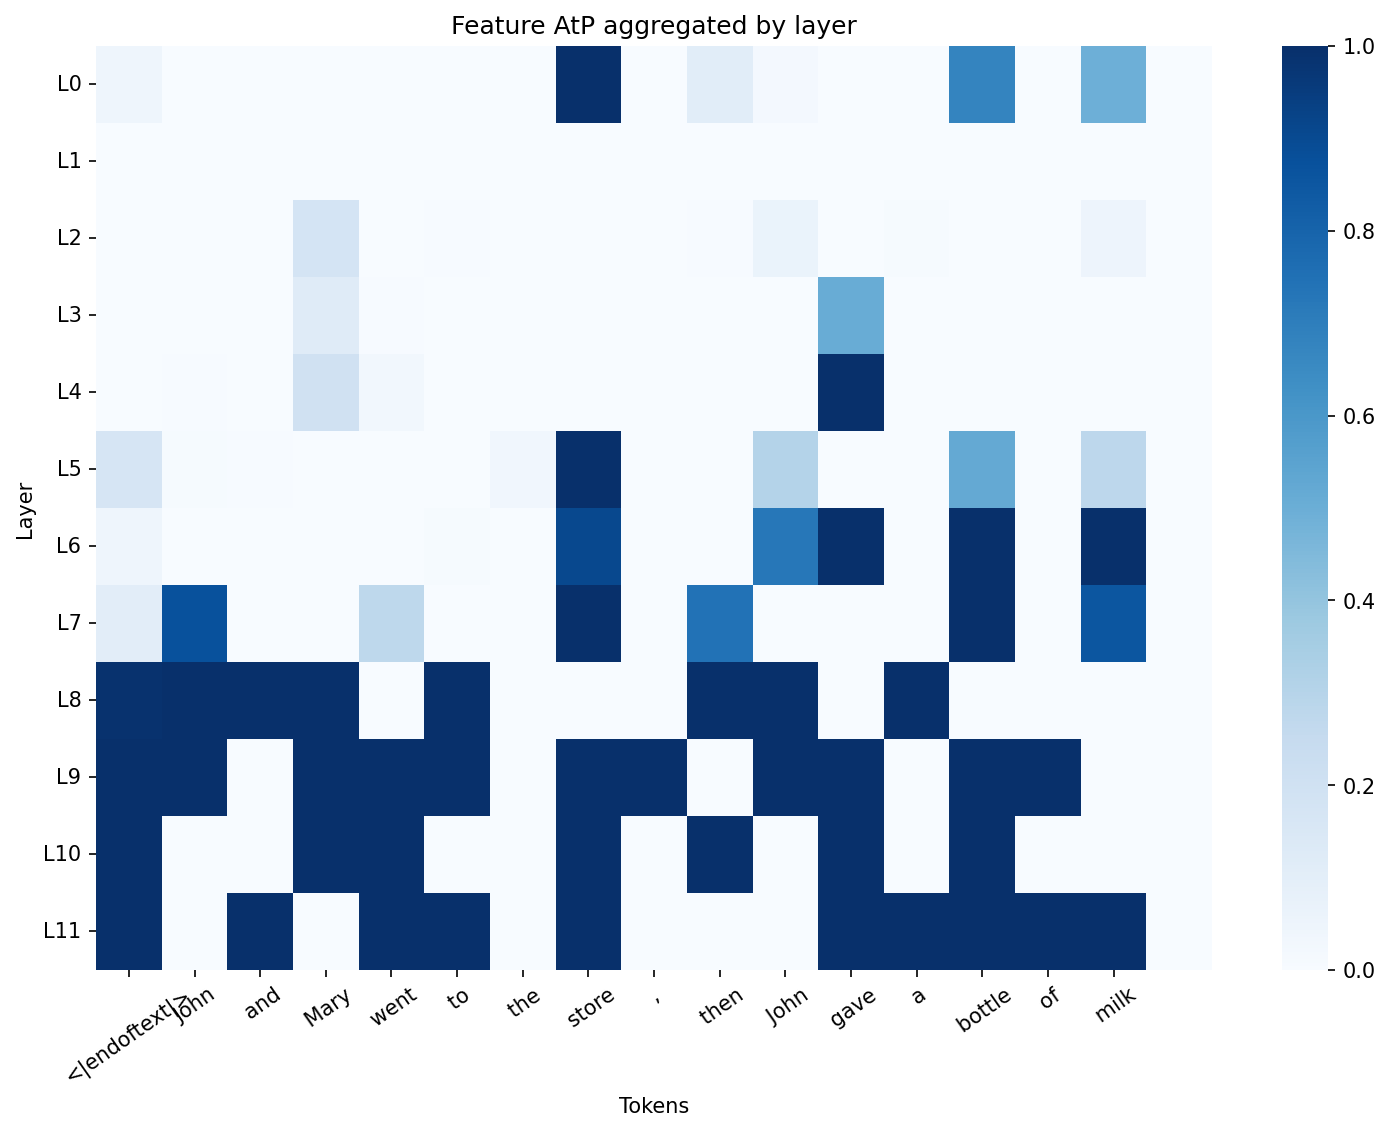

In [153]:
plt.figure(figsize=(12, 8), dpi=150)

ys = [f"L{i}" for i in range(model.cfg.n_layers)]

# Draw the heatmap
ax = sns.heatmap(patch.cpu().sum(-1), cmap='Blues', vmin=0, vmax=1)

# Set tick labels
ax.set_xticks([i + 0.5 for i in range(len(labels))])  # Set x-ticks every 10 columns
ax.set_yticks([i + 0.5 for i in range(len(ys))])  # Set y-ticks every 10 rows

# Set tick labels with optional custom labeling
ax.set_xticklabels(labels)
ax.set_yticklabels(ys)

# Rotate tick labels for better visibility
plt.xticks(rotation=35)
plt.yticks(rotation=0)

# Title and labels (optional)
plt.title('Feature AtP aggregated by layer')
plt.xlabel('Tokens')
plt.ylabel('Layer')

# Show the plot
plt.show()

In [170]:
def reconstr_hook(x, hook, sae):
    sae_out, f_act, *_ = sae(x)
    sae_cache[hook.name] = f_act  # Store for reference; not detach here as we need gradients
    return sae_out

def interpolate(input, baseline, steps=50):
    return [baseline + (float(i) / steps) * (input - baseline) for i in range(steps + 1)]


In [171]:
# IG
from functools import partial

# Generate baseline
baseline_tokens = torch.zeros_like(tokens)

# Interpolate between baseline and actual tokens
interpolated_inputs = interpolate(tokens, baseline_tokens, steps=50)

# Container for accumulated gradients
accumulated_grads = []

for interp_tokens in interpolated_inputs:
    # Run model forward with hooks
    out = model.run_with_hooks(
                interp_tokens,
                fwd_hooks=[
                    (
                        utils.get_act_name(component, layer_id),
                        partial(reconstr_hook, sae=saes[layer_id]),
                    ) for layer_id in range(model.cfg.n_layers)
                ]
            ).log_softmax(-1)
    
    # Target token
    ans = model.to_single_token('Mary')
    loss = -out[0, -1, ans]  # Assuming scalar output for simplification

    # Backward to get gradients on interpolated inputs
    loss.backward()

    # Collect gradients from SAE features
    for name in sae_cache:
        if sae_cache[name].grad is not None:
            if name not in accumulated_grads:
                accumulated_grads[name] = []
            accumulated_grads[name].append(sae_cache[name].grad.clone())

    # Zero all gradients for the next iteration
    model.zero_grad()

# Average the gradients across all steps
integrated_gradients = {name: torch.stack(grads).mean(0) * (tokens - baseline_tokens) for name, grads in accumulated_grads.items()}


IndexError: tensors used as indices must be long, int, byte or bool tensors

In [23]:
json_text = """{
    "question": "What's the capital of France?",
    "answer": Paris
    }"""

non_json_text = [
    """What's the capital of France?
Paris""",
    """These are the things I love:
1. Food,
2. Sea,
3. Friends""",
    """An old man once told me: "You will succeed in life".
I hope him to be true."""
]

In [7]:
features_dict = {l: [] for l in range(model.cfg.n_layers)}

with open("json_features.txt", "r") as f:
    features = f.readlines()

for f in features:
    f = f.strip().split('-')
    layer = int(f[0])
    features_dict[layer].append(f[1])

In [26]:
features_act_dict = {
    'L': [],
    'N': [],
    'JSON Activation': [],
    'Non-JSON Activation': []
}

with torch.no_grad():
    _, json_cache = model.run_with_cache(model.to_tokens(json_text))
    _, non_json_cache = model.run_with_cache(model.to_tokens(non_json_text[2]))

for l in range(model.cfg.n_layers):
    json_activations = json_cache[f'blocks.{l}.hook_resid_pre'] # [1 p dm]
    non_json_activations = non_json_cache[f'blocks.{l}.hook_resid_pre'] # [1 p dm]

    with torch.no_grad():
        _, json_features_act, *_ = saes[l](json_activations)
        _, non_json_features_act, *_ = saes[l](non_json_activations)

    for f in features_dict[l]:
        f = int(f)
        features_act_dict['L'].append(l)
        features_act_dict['N'].append(f)
        val, ix = json_features_act[0, :, f].max(0)
        features_act_dict['JSON Activation'].append([val.item(), ix.item()])
        val, ix = non_json_features_act[0, :, f].max(0)
        features_act_dict['Non-JSON Activation'].append([val.item(), ix.item()])        

In [27]:
import pandas as pd

pd.DataFrame(features_act_dict)

,L,N,JSON Activation,Non-JSON Activation
0,0,23622,"[0.0, 0]","[0.0, 0]"
1,1,5310,"[20.185184478759766, 8]","[0.0, 0]"
2,2,10521,"[25.650108337402344, 8]","[0.0, 0]"
3,4,21672,"[3.7655177116394043, 9]","[0.0, 0]"
4,4,8148,"[1.687551736831665, 18]","[0.0, 0]"
5,6,5682,"[24.25801658630371, 23]","[0.0, 0]"
6,6,3596,"[21.313154220581055, 2]","[0.0, 0]"
7,6,13428,"[0.9894517660140991, 8]","[0.0, 0]"
8,6,2164,"[0.0, 0]","[0.0, 0]"
9,7,20690,"[25.253623962402344, 23]","[0.0, 0]"


In [21]:
list(enumerate(model.to_str_tokens(json_text)))

[(0, '<|endoftext|>'),
 (1, '{'),
 (2, '\n'),
 (3, ' '),
 (4, ' '),
 (5, ' '),
 (6, ' "'),
 (7, 'question'),
 (8, '":'),
 (9, ' "'),
 (10, 'What'),
 (11, "'s"),
 (12, ' the'),
 (13, ' capital'),
 (14, ' of'),
 (15, ' France'),
 (16, '?",'),
 (17, '\n'),
 (18, ' '),
 (19, ' '),
 (20, ' '),
 (21, ' "'),
 (22, 'answer'),
 (23, '":'),
 (24, ' Paris'),
 (25, '\n'),
 (26, ' '),
 (27, ' '),
 (28, ' '),
 (29, ' }')]

## Sentiment Analysis

### Baseline